---
title: "Tackling Tabular Problems I: Exploratory Data Analysis"
date: "2022-10-27"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

## Exploratory Data Analysis

Given a dataset, the first step with every new problem is exploratory data analysis (EDA). Initially, we'll just want to get a good general understanding of the data (using descriptive statistics, histograms, searching for duplicates, etc.). Ideally, we'll recognize peculiarities of the data that warrant further exploration and ultimately lead to finding good features. There are specific issues, however, that usually require special attention:

- **Missing values**: Missing values are a common issue. Assuming that there is enough data to work with, the most important question is how missingness is related to the target. Imagine that we want to predict whether a machine is going to fail, for example. It may turn out that missing values for one particular sensor are associated with a higher failure rate of the machine (maybe some downstream process relies on the sensor data or a problem with an upstream process causes the value to exceed the sensor's measurement range; in any case, this would require further investigation). Thus, imputation should never be the first step when dealing with missing data (more on this later).
- **Outliers**: Analyzing outliers often can be challenging. After all it requires domain knowledge to determine whether a particular observation really has occurred, whether it should be treated in some way or even can be safely ignored. Finding outliers also isn't confined to the univariate case. Looking for rare combinations of variables can reveal further interesting patterns (e.g., it may be very uncommon for two features to be very high at the same time and this tells us something about the target).
- **Skewed numerical variables**: Analyze the data to identify variables that may require a transformation. Ultimately, transforming variables can be a question of interpretability or feature engineering (i.e., which transformation improves the performance of the model), or it can be dictated by the model.
- **Model validation**: Setting up a robust validation scheme requires a thorough understanding of the data. It is advantageous to already have model validation in mind when exploring the data (i.e., watch out for issues like groups in the data that need to be addressed by the validation scheme).
- **Feature engineering**: Many ideas for feature engineering will arise while exploring the data. Which features will help us predict the target? Which features should be combined? Which features are redundant? Which features only represent noise? It is beneficial to take note of these findings (and, even more importantly, the intuition behind them) and investigate them further.

There are many methods to gather relevant insights. Let's quickly go through the most common ones:

- Descriptive statistics and histograms for single variables (using an automatic tool like [pandas-profiling](https://pandas-profiling.ydata.ai/docs/master/pages/getting_started/overview.html) for this purpose can be very time-efficient).
- Scatterplots, box plots, bar charts, etc. for visualizing two or three variables together. Visualize a third variable (often the target) using color (e.g., in scatterplots) or by varying another property of the plot (e.g., the width of the bars in bar charts).
- Dimensionality reduction: [t-SNE](https://distill.pub/2016/misread-tsne/) and [UMAP](https://pair-code.github.io/understanding-umap/) are two great techniques for reducing the dimensionality of the data, potentially revealing clusters and outliers (note that getting the most out of both algorithms can be somewhat challenging; see the provided links for more on this). Using the implementations in [cuml](https://github.com/rapidsai/cuml) for GPU acceleration is recommended for time-efficiency.

## Example: Rocket League

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
import imageio.v2 as imageio
import gc
import os
from pathlib import Path
from tqdm import tqdm

As an example for this series about tabular problems, we'll use a custom subset of a [dataset](https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/data) containing snapshots of professional Rocket League matches. ([Rocket League](https://en.wikipedia.org/wiki/Rocket_League) is a video game where two teams use rocket-powered vehicles to play soccer.) I've picked this dataset because it is quite intuitive, can be visualized nicely, requires attention when setting up the validation scheme, and offers vast possibilities for feature engineering. If you, like me, have never heard of Rocket League, that's not a problem – there is a huge amount of recorded gameplay on YouTube, if you are curious. Our goal will be to predict, based on a *single* snapshot of a game, the probability that team A will score within the next 10 seconds.

Let's get a quick overview of the available features:
- `game_num`: unique identifier for the game from which the event was taken
- `event_id`: unique identifier for the sequence of consecutive frames
- `event_time`: time in seconds before the event ended, either by a goal being scored or by truncation if a goal wasn't scored; only in train
- `team_A_scoring_within_10sec`: the target column; `1` if the team scores in the next 10 seconds of the game, `0` otherwise
- `team_B_scoring_within_10sec`: only in train
- Ball:
    - `ball_pos_[xyz]`: position of the ball as a 3d vector
    - `ball_vel_[xyz]`: velocity of the ball as a 3d vector
- Players:
    - `p{i}_pos_[xyz]`: position of player $i$ as a 3d vector
    - `p{i}_vel_[xyz]`: velocity of player $i$ as a 3d vector
    - `p{i}_boost`: remaining boost of player $i$
    - Note: All columns related to a specific player will be `NaN` if the player has been demolished and hasn't respawned yet. Team `A` consists of players 0, 1, and 2; Team `B` consists of player 3, 4, and 5.
- Boost:
    - `boost{i}_timer`: time in seconds until big boost orb i respawns, `0` if it is available

Let's see what EDA can reveal about the dataset.

In [41]:
data_path = Path("/kaggle/input/rocket-league-ds/train.feather")

In [42]:
df = pd.read_feather(data_path)

### Games and events

The dataset contains data for 5865 games and 24295 unique events. On average, there are more than four events per game. Per event we have between 1 and over 1,291 observations.

In [43]:
print("Number of games:", df.game_num.unique().shape[0])
print("Number of events:", df.event_id.unique().shape[0])

print("\nEvents per game:\n", df.groupby("game_num").event_id.unique().agg(len).agg(["min", "max", "mean", "median", "std"]))

print("\nObservations per event:\n", df.groupby("event_id").size().agg(["min", "max", "mean", "median", "std"]))

Number of games: 5865
Number of events: 24295

Events per game:
 min        1.000000
max       11.000000
mean       4.142370
median     4.000000
std        1.687877
Name: event_id, dtype: float64

Observations per event:
 min          1.000000
max       1291.000000
mean        98.599136
median      71.000000
std         89.669409
dtype: float64


In general, though, very long events are the exception:

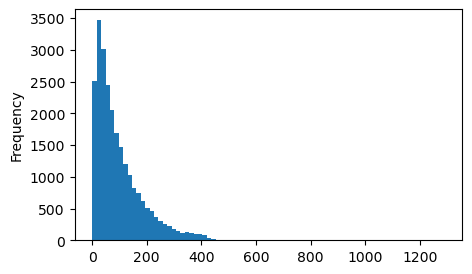

In [44]:
df.groupby("event_id").size().plot.hist(bins=80, figsize=(5, 3));

### Ball position

The position of the ball's center point is provided with `x`, `y`, and `z` coordinates in the `ball_pos_[xyz]` features. The histograms below show the following:
- The pitch is around `160` units wide, `200` units long, and `40` units high.
- All dimensions are centered, which means that the point `[0, 0 ,0]` is where the kick-off happens (i.e. where each game begins and resumes after a goal).
- The most common ball positions for all dimensions are `0`. This is not surprising because all events in the dataset begin with a kick-off. 
- For the `x` dimension, values at the sides of the pitch appear more often.
- For the `y` dimension, the histogram shows that the gameplay is somewhat orientated towards the goals. The rather small values at either side probably reflect that the ball was in the respective goal.
- For the `z` dimension, we can see that higher values appear increasingly less frequently. Still, the ball is quite often flying in the air.

Ball positions (min/max):
x coordinate: min = -80.600	 max = 80.663
y coordinate: min = -104.309	 max = 104.308
z coordinate: min = 1.142	 max = 39.428


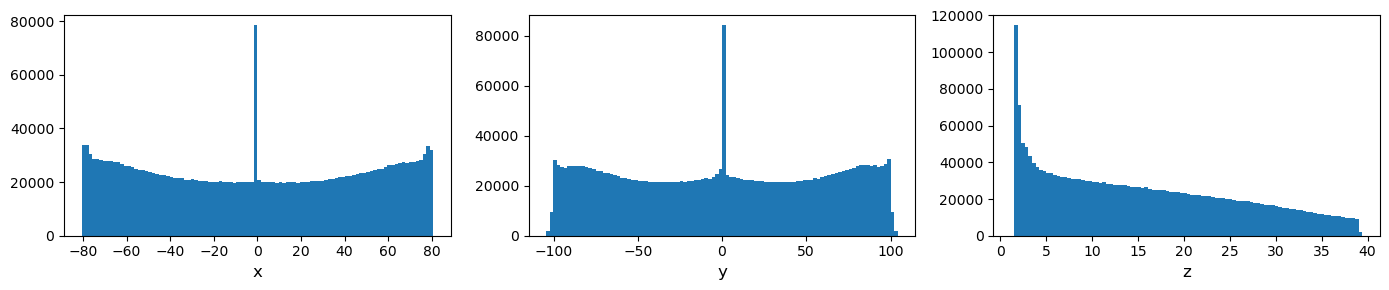

In [45]:
print("Ball positions (min/max):")
for coord in ["x", "y", "z"]:
    mi, ma = df[f"ball_pos_{coord}"].min(), df[f"ball_pos_{coord}"].max()
    print(f"{coord} coordinate: min = {mi:.3f}\t max = {ma:.3f}")

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"ball_pos_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.tight_layout()

#### Size of the pitch and position of the goals

Let's focus on observations where the ball is inside the goal.

We can see that:
- the goals are centered at `x=0` on either side of the pitch
- the goal lines are at `y=-100` and `y=100`, respectively
- the goals are around `35` units wide and `12` units high
- if a goal is scored:
    -  the `x` position of the ball when crossing the goal line is essentially uniformly distributed
    -  the ball sometimes just barely crosses the goal line (see the two small bars of the histogram for the `y` dimension)
    -  most goals are scored with the ball rolling on the pitch (or flying very low), otherwise the `z` dimension is quite uniformly distributed

x coordinate: min = 0.001	 max = 16.379
y coordinate: min = 102.001	 max = 104.309
z coordinate: min = 1.606	 max = 11.085


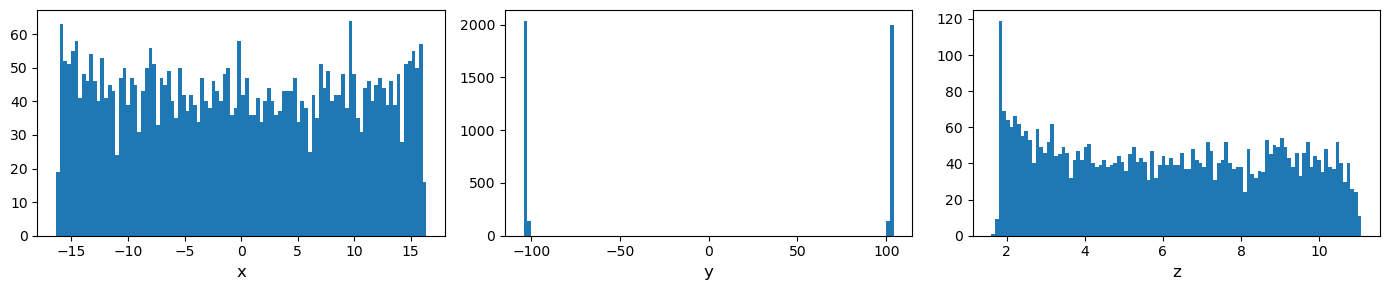

In [46]:
tmp = df.loc[df.ball_pos_y.abs() > 102]

for coord in ["x", "y", "z"]:
    abs_ = tmp[f"ball_pos_{coord}"].abs()
    mi, ma = abs_.min(), abs_.max()
    print(f"{coord} coordinate: min = {mi:.3f}\t max = {ma:.3f}")
    
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(tmp[f"ball_pos_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.tight_layout()

We can also simply plot all ball positions in the dataset. Apart from seeing the goals, this allows us to notice the indented shape of the corners of the pitch:

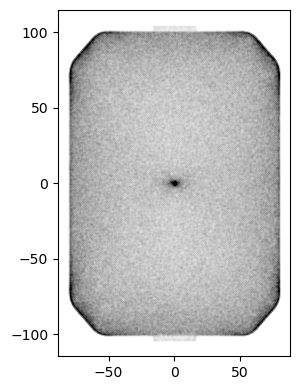

In [47]:
fig, ax = plt.subplots(figsize=(3, 4.5))
subset = df.sample(n=int(1e6), random_state=1)
ax.scatter(subset.ball_pos_x, subset.ball_pos_y, s=0.1, alpha=0.01, color="black");

#### Ball position and goal scoring

It seems natural that the position of the ball is related to our target. Let's plot the ball positions (the `x` and `y` dimension for now) depending on the outcome. There are a few things to notice:
- If either team scores in the next ten seconds, the ball unsurprisingly tends to be in the half of the defending team, particularly in front of the goal.
- It seems to be common that a goal is scored in the 10 seconds after kick-off (since we can clearly see the center spot in the scatterplots).

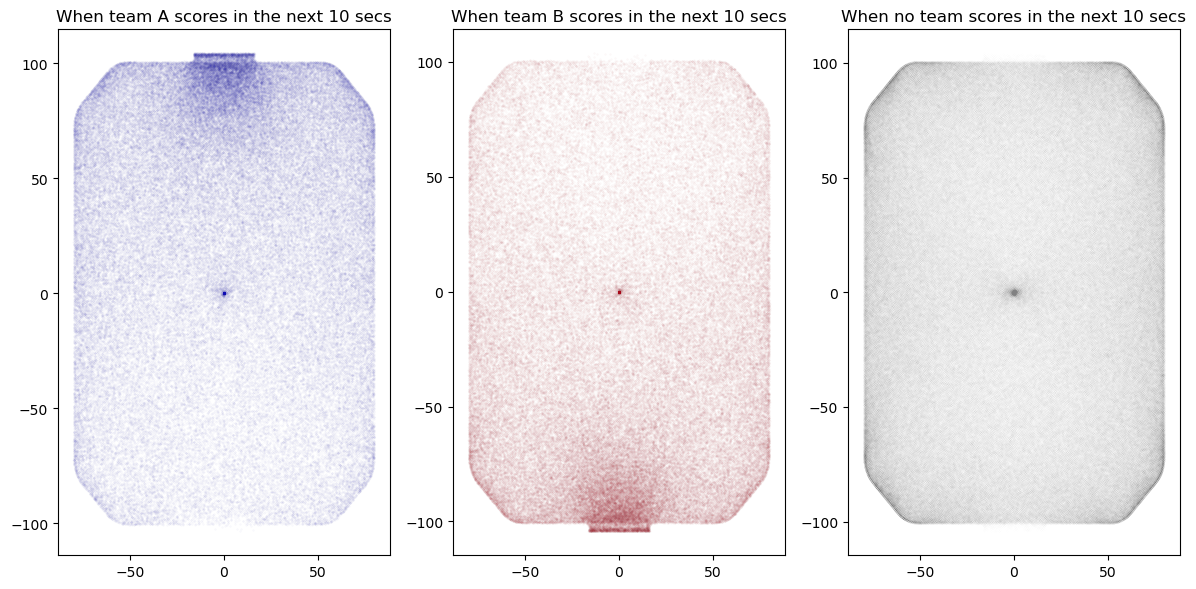

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
team_A_scores = df[df.team_A_scoring_within_10sec == 1]
team_B_scores = df[df.team_B_scoring_within_10sec == 1]
no_goal = df[(df.team_A_scoring_within_10sec == 0) & (df.team_B_scoring_within_10sec == 0)]
no_goal = no_goal.sample(n=int(1e6), random_state=1)
axs[0].scatter(team_A_scores.ball_pos_x, team_A_scores.ball_pos_y, s=0.1, alpha=0.05, color="#0f0cb3")
axs[0].set_title("When team A scores in the next 10 secs")
axs[1].scatter(team_B_scores.ball_pos_x, team_B_scores.ball_pos_y, s=0.1, alpha=0.05, color="#a60717")
axs[1].set_title("When team B scores in the next 10 secs")
axs[2].scatter(no_goal.ball_pos_x, no_goal.ball_pos_y, s=0.01, alpha=0.05, color="#818182")
axs[2].set_title("When no team scores in the next 10 secs")
fig.tight_layout();

Now it might be interesting to what changes when we alter the time until the goal is scored. Let's plot the same scatterplots for the intervals `[7, 6]`, `[5, 4]`, `[3, 2]`, `[2, 1]`, and `[1, 0.1]`. 

What can we learn from the plots? 

While there are no obvious patterns in earlier time steps (when the gameplay appears to be quite spread out all over the pitch), the game usually begins to shift to the half of the defending team at around 5 seconds before a goal. Then it gets further condensed as time progresses. 2 to 1 seconds before a goal, the gameplay is typically thoroughly concentrated in the half of the defending team, particularly in its center as well as directly in front of the goal. This continues until the very last time steps when the ball generally is directly in front of or already partly in the goal. 

When we focus on the center spot, we can see that some goals are scored only 7 to 5 seconds after kick-off. This holds true (though to a lesser extent) for the `[5, 4]` and even the `[3, 2]` interval. Afterwards the center spot vanishes in the scatterplots, meaning that goals in less than 2 seconds after kick-off are very rare.

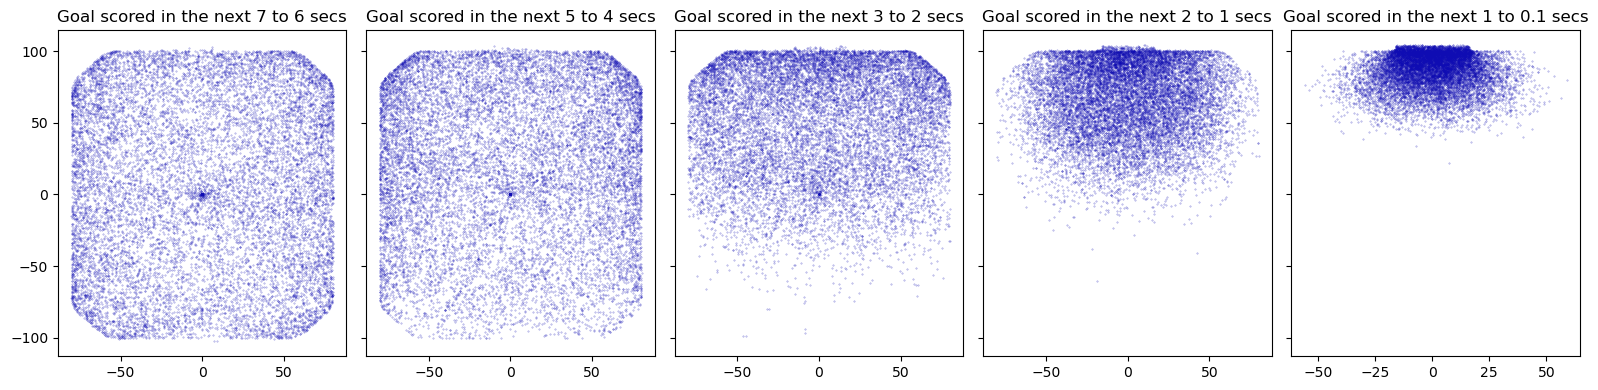

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[col].scatter(tmp.ball_pos_x, tmp.ball_pos_y, s=0.1, alpha=.5, color="#0f0cb3")
    axs[col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
fig.tight_layout();

What about the `z` dimension? Let's plot `y` against `z`. What is somewhat surprising is that some goals appear to be scored from a nearly vertical angle.

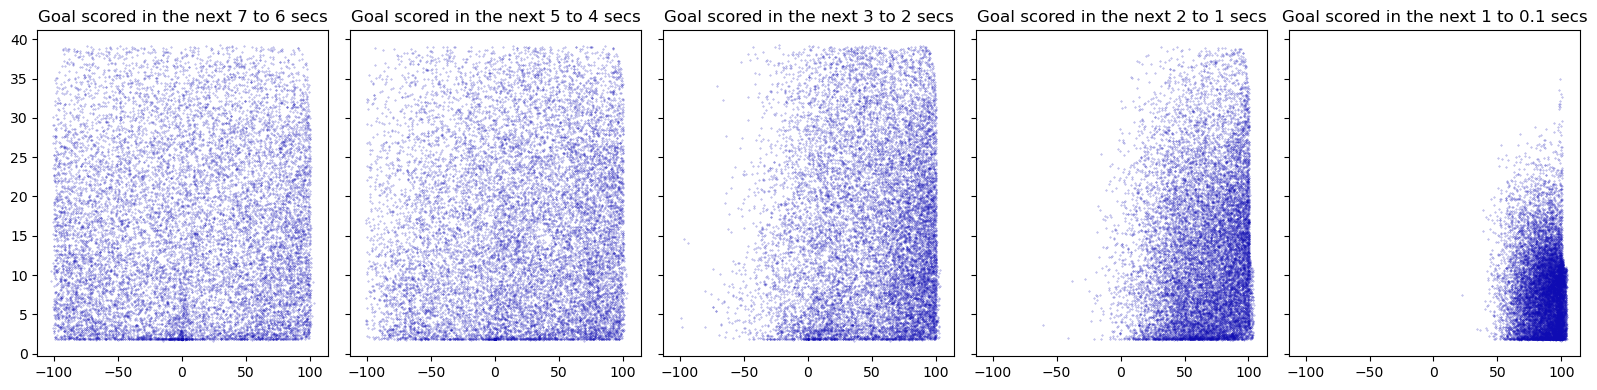

In [73]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharex=True, sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[col].scatter(tmp.ball_pos_y, tmp.ball_pos_z, s=0.1, alpha=.5, color="#0f0cb3")
    axs[col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
fig.tight_layout();

Finally, let's plot `x` against `z`:

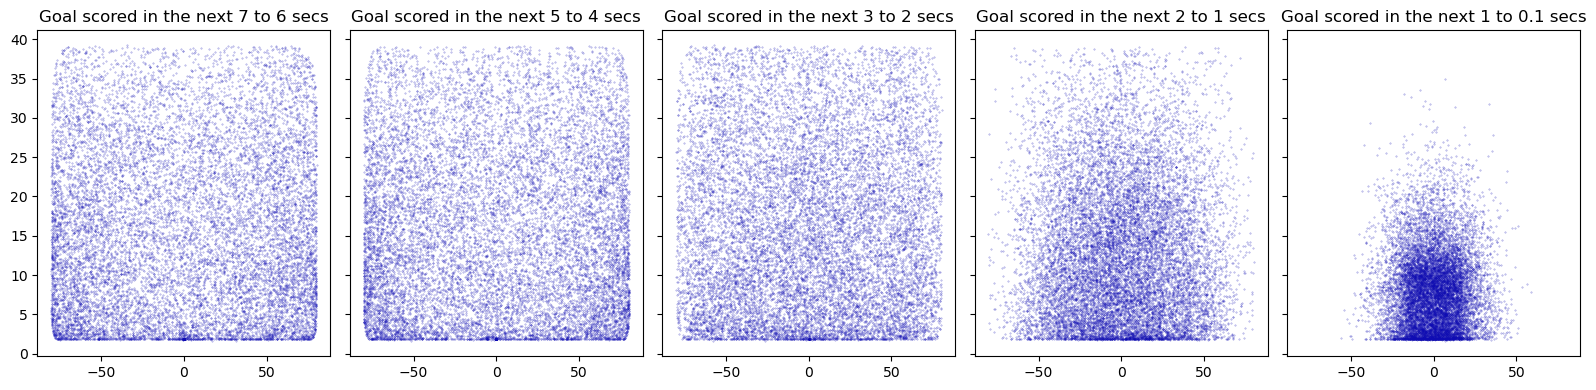

In [74]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharex=True, sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[col].scatter(tmp.ball_pos_x, tmp.ball_pos_z, s=0.1, alpha=.5, color="#0f0cb3")
    axs[col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
fig.tight_layout();

### Ball velocity

The velocity of the ball is provided as a 3d vector by the `ball_vel_[xyz]` features. The histograms for each dimension don't contain any big surprises (the maxima at `0` are due to the kick-off), only the two local maxima of the `y` dimension are striking. 

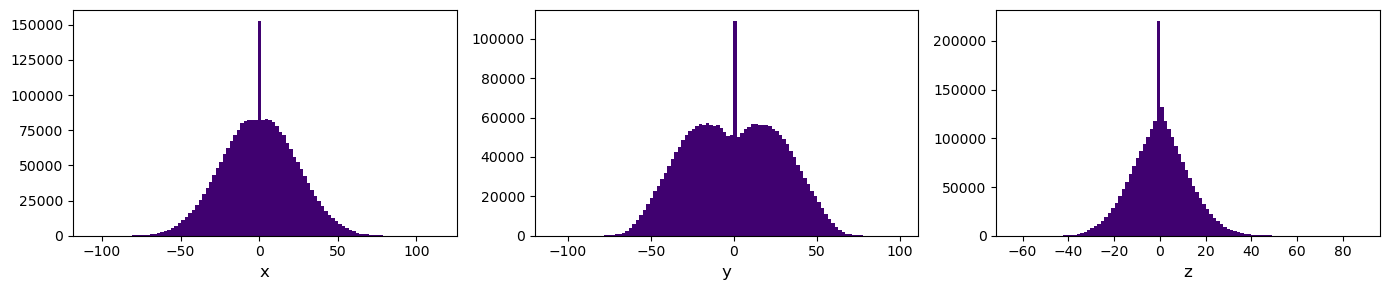

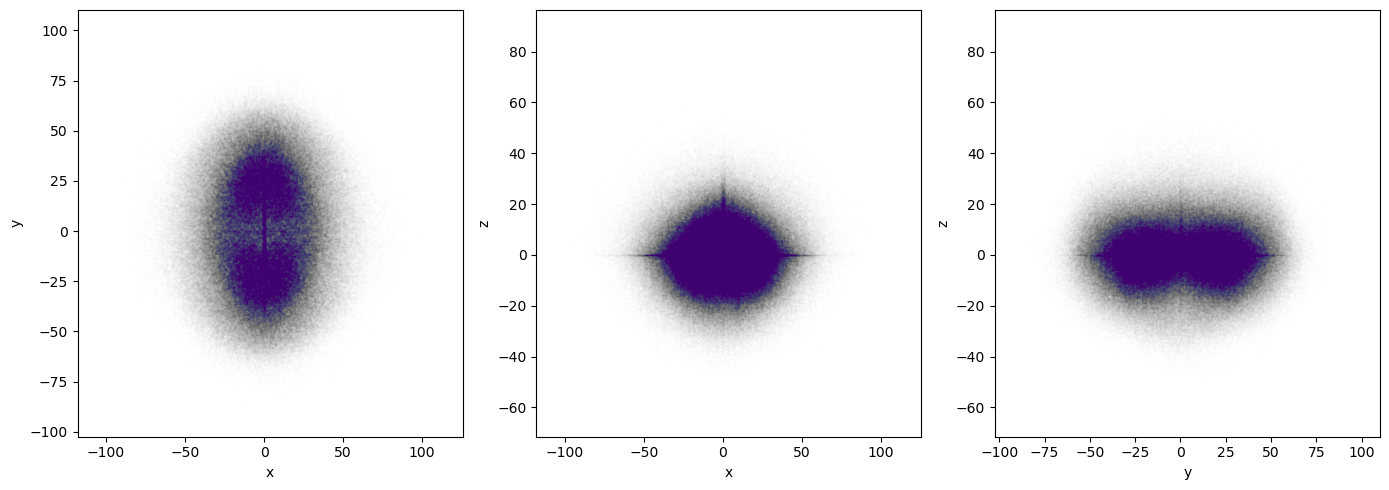

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"ball_vel_{f}"], bins=100, color="#400170")
    ax.set_xlabel(f, fontsize=12)
fig.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
tmp = df.sample(n=int(1e6), random_state=1)
axs[0].scatter(tmp.ball_vel_x, tmp.ball_vel_y, s=0.1, alpha=0.01, color="#400170")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[1].scatter(tmp.ball_vel_x, tmp.ball_vel_z, s=0.1, alpha=0.01, color="#400170")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")
axs[2].scatter(tmp.ball_vel_y, tmp.ball_vel_z, s=0.1, alpha=0.01, color="#400170")
axs[2].set_xlabel("y")
axs[2].set_ylabel("z")
fig.tight_layout()

#### Ball velocity and goal scoring

Is there a relationship between the velocity of the ball and the scoring of a goal? Let's see. We'll plot scatterplots of all three dimensions of the velocity vector for different time intervals (the `y` axis of the plot shows the interval mean) before a goal.

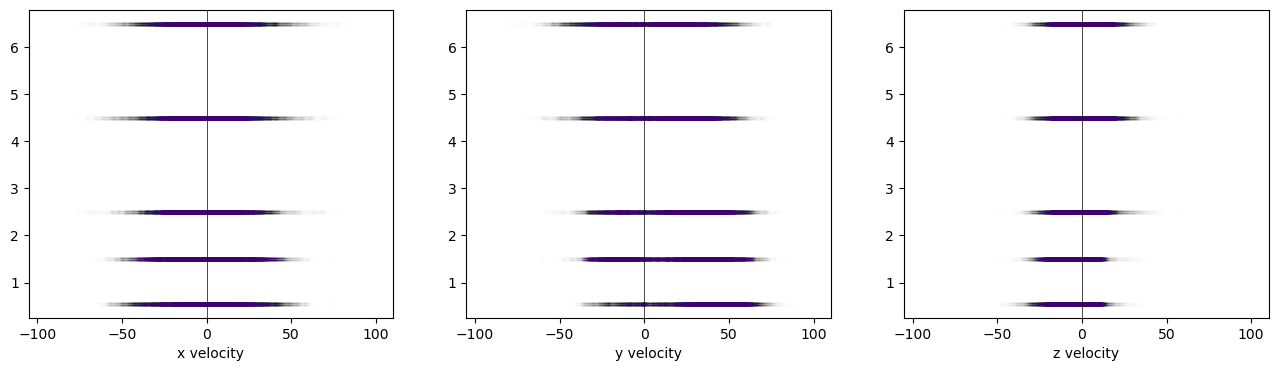

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, c in enumerate(["x", "y", "z"]):
    axs[col].set_xlabel(f"{c} velocity")
    axs[col].axvline(0, color="black", lw=0.5)
    for interval in intervals:
        tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
        tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
        m = abs(interval[0] + interval[1])/2
        axs[col].scatter(tmp[f"ball_vel_{c}"], np.repeat(m, tmp.shape[0]), s=7.5, alpha=.005, color="#400170")

- The `x` values are centered with no extreme values in either direction (this is not surprising given the position of the goal). 
- The `y` values are increasingly shifted to positive values. Since we are looking at team `A` (which attacks in the direction of positive `y` values), this not surprising, too. With only a few seconds left before the goal, there are a quite lot samples with negative `y` velocities, though.
- The `z` values narrow the closer we get to the goal and get somewhat shifted in the negative direction. Given that goals can be scored from flying cars, this is to be expected, but still interesting.

Finally we can plot the dimensions against each other.

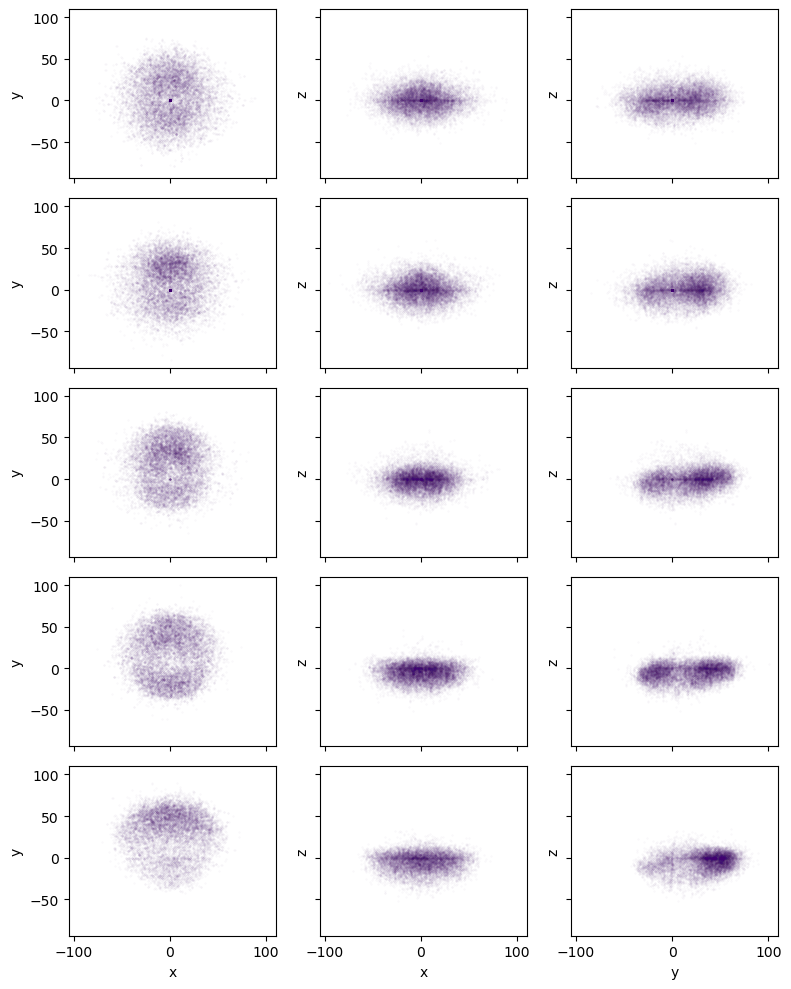

In [77]:
fig, axs = plt.subplots(5, 3, figsize=(8, 10), sharex=True, sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for row, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[row][0].scatter(tmp.ball_vel_x, tmp.ball_vel_y, s=0.1, alpha=0.05, color="#400170")
    if row == 4: axs[row][0].set_xlabel("x")
    axs[row][0].set_ylabel("y")
    axs[row][1].scatter(tmp.ball_vel_x, tmp.ball_vel_z, s=0.1, alpha=0.05, color="#400170")
    if row == 4: axs[row][1].set_xlabel("x")
    axs[row][1].set_ylabel("z")
    axs[row][2].scatter(tmp.ball_vel_y, tmp.ball_vel_z, s=0.1, alpha=0.05, color="#400170")
    if row == 4: axs[row][2].set_xlabel("y")
    axs[row][2].set_ylabel("z")
fig.tight_layout();

### Player position

The position of player `i` is provided with `x`, `y`, and `z` coordinates in the `p{i}_pos_[xyz]` features. Since the histograms of members of the same team are identical, only histograms for player `0` (first player of team A) and `3` (first player of team B) are shown. As expected, they are essentially mirror images. The histograms show the following:
- For the `x` dimension, values at the center and the extremes are the most common. The latter is probably due to the fact that cars can drive up the walls to gain height.
- For the `y` dimension, we can see that players are more often in their own half of the pitch than in the half of their opponents (team A attacks in the direction of positive `y` values). There are peaks on both goal lines, in front of the goals, and in the center of the pitch. 
- For the `z` dimension, we can see that high values appear quite rarely (in stark contrast to the ball). As mentioned earlier, the cars require "boost" (which is not abundantly available) to fly in the `z` dimension.

Player positions (min/max):
x coordinate: min = -81.904	 max = 81.931
y coordinate: min = -119.820	 max = 119.766
z coordinate: min = 0.026	 max = 40.862


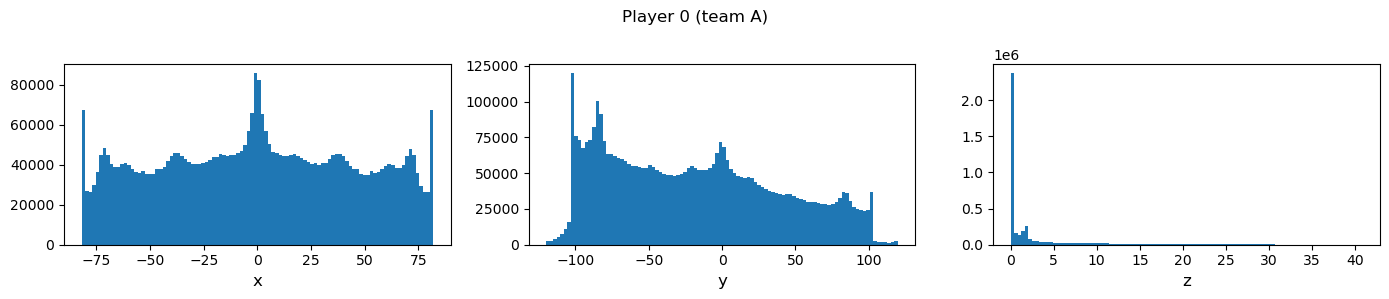

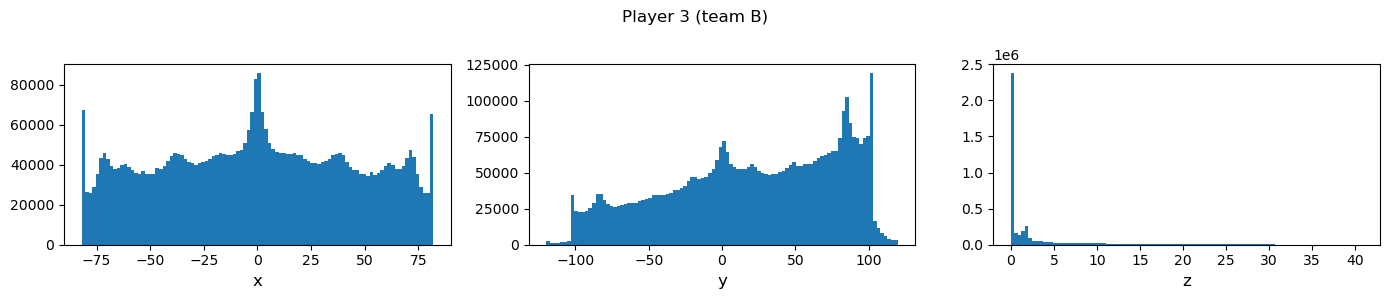

In [18]:
print("Player positions (min/max):")
for coord in ["x", "y", "z"]:
    mi, ma = df[f"p0_pos_{coord}"].min(), df[f"p0_pos_{coord}"].max()
    print(f"{coord} coordinate: min = {mi:.3f}\t max = {ma:.3f}")

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"p{0}_pos_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.suptitle("Player 0 (team A)")
fig.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"p{3}_pos_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.suptitle("Player 3 (team B)")
fig.tight_layout()

Of course, we can also plot all available player positions in the dataset on a map. The "big boost orbs" (more on them soon) are highlighted by black circles (only in the first column for better visibility).

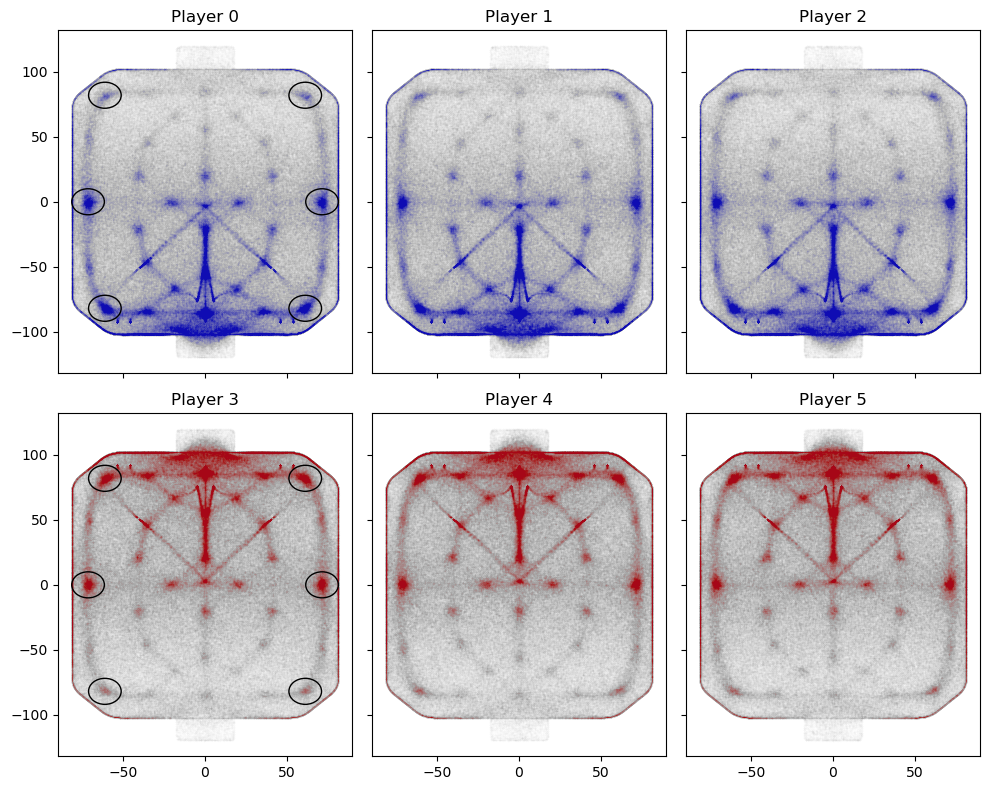

In [78]:
def draw_boost_orbs(ax):
    for x, y in [(-61.4, -81.9), (61.4, -81.9), (-71.7, 0), (71.7, 0), (-61.4, 81.9), (61.4, 81.9)]:
        ax.add_patch(patches.Circle((x, y), 10, color="black", fill=False))

fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)
tmp = df.sample(n=int(1e6), random_state=1)
for col, p in enumerate(range(3)):
    axs[0][col].scatter(tmp[f"p{p}_pos_x"], tmp[f"p{p}_pos_y"], s=0.1, alpha=0.015, color="#0f0cb3")
    axs[0][col].set_title(f"Player {p}")
    if col == 0: draw_boost_orbs(axs[0][col])
    axs[1][col].scatter(tmp[f"p{p+3}_pos_x"], tmp[f"p{p+3}_pos_y"], s=0.1, alpha=0.015, color="#a60717")
    axs[1][col].set_title(f"Player {p+3}")
    if col == 0: draw_boost_orbs(axs[1][col])
fig.tight_layout();

The plots show many apparent visual structures. Maybe these can be explained by the starting positions of the players, the boost positions (the big boost orbs at both sides certainly attract players), and preferred routes to drive up walls. We can also see that the most common defending positions are in an arc in front of the goal, sometimes defending players even drive partly inside their own goal. Generally there appear to be no differences between players and teams.

#### Player position and goal scoring

Let's see whether the visual structures disappear when we sort the data by the amount of time until a goal is scored. Since players of the same team don't show any differences, we'll only look at players 0 (when attacking) and 3 (when defending), respectively.

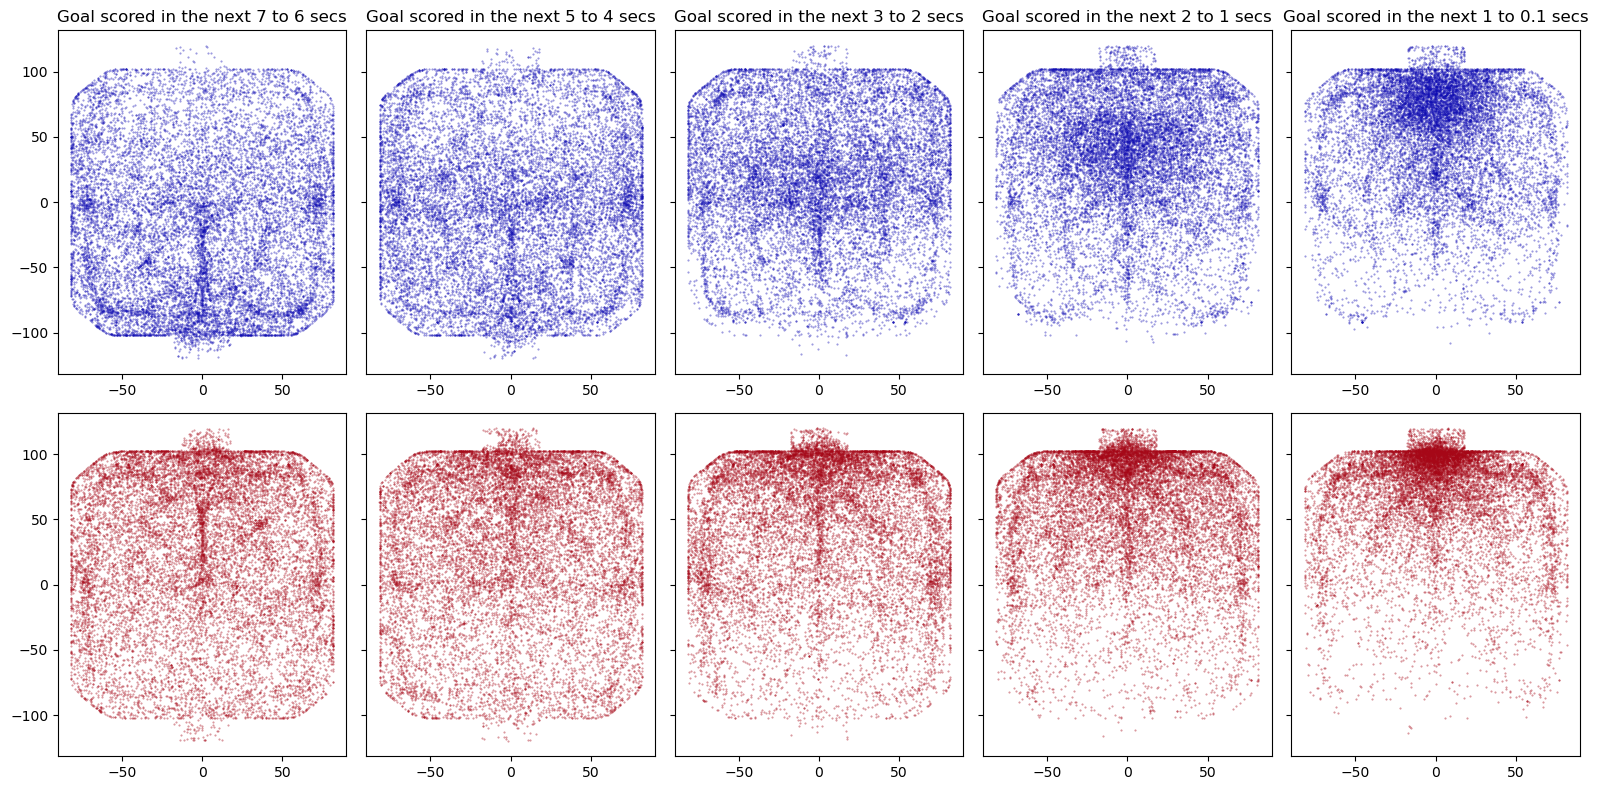

In [85]:
fig, axs = plt.subplots(2, 5, figsize=(16, 8), sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[0][col].scatter(tmp.p0_pos_x, tmp.p0_pos_y, s=0.2, alpha=.5, color="#0f0cb3")
    axs[0][col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
    axs[1][col].scatter(tmp.p3_pos_x, tmp.p3_pos_y, s=0.2, alpha=.5, color="#a60717")
fig.tight_layout();

Now it gets interesting. Some structures that we've just seen have now disappeared, but not all of them. We can clearly see that in the first and second interval (7 to 4 seconds before the goal) players of the attacking team are not necessarily in the half of their opponents (in fact, they are in their own half more often than not). This changes afterwards: the bulk of recorded positions of attacking players consistently moves towards the side of the team that will soon concede the goal and becomes increasingly centered. Meanwhile defending players increasingly move centrally towards their own goal and are usually positioned directly in front of their goal just before the goal is scored. The distance of the players (and teams) to the ball and the goal(s) will likely be very useful predictors.

Let's move on to plotting the `x` versus the `z` dimension (we'll skip the first interval). We only look events that end with a goal for team `A`.

If the players use their boost to fly, they position themselves more centrally in front of the goal the closer in time we get to the scored goal. Attacking players use more of the height and width of the pitch than defending players.

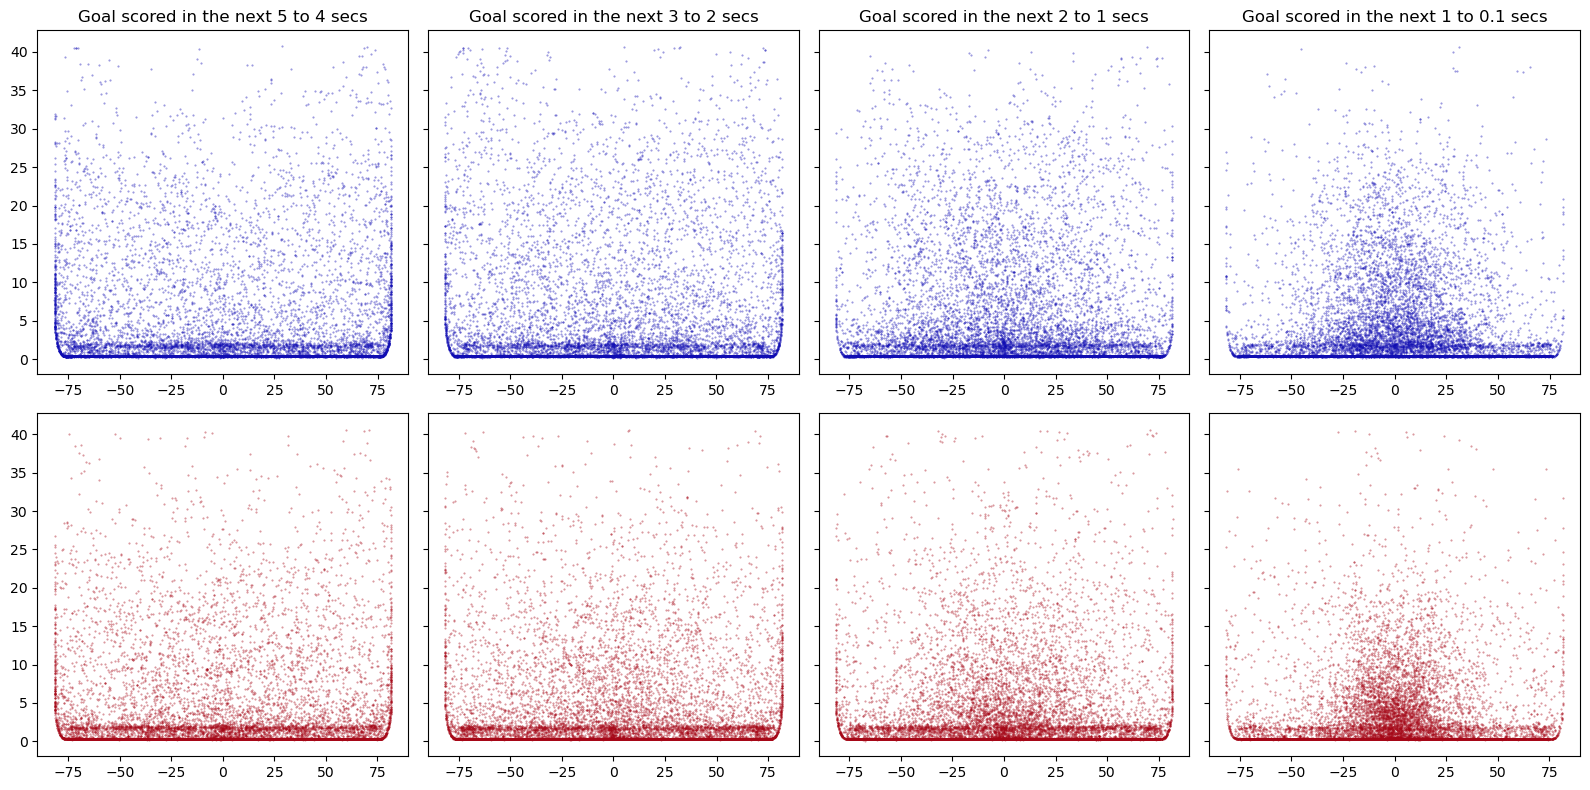

In [86]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
intervals = [(-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[0][col].scatter(tmp.p0_pos_x, tmp.p0_pos_z, s=0.2, alpha=.5, color="#0f0cb3")
    axs[0][col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
    axs[1][col].scatter(tmp.p3_pos_x, tmp.p3_pos_z, s=0.2, alpha=.5, color="#a60717")
fig.tight_layout();

What about the `y` versus the `z` dimension (we'll again skip the first interval)?

The players of both teams move consistently towards the goal (whether they fly or not) the closer in time we get to the goal with the defending players trying to block the attackers directly in front of the goal. 

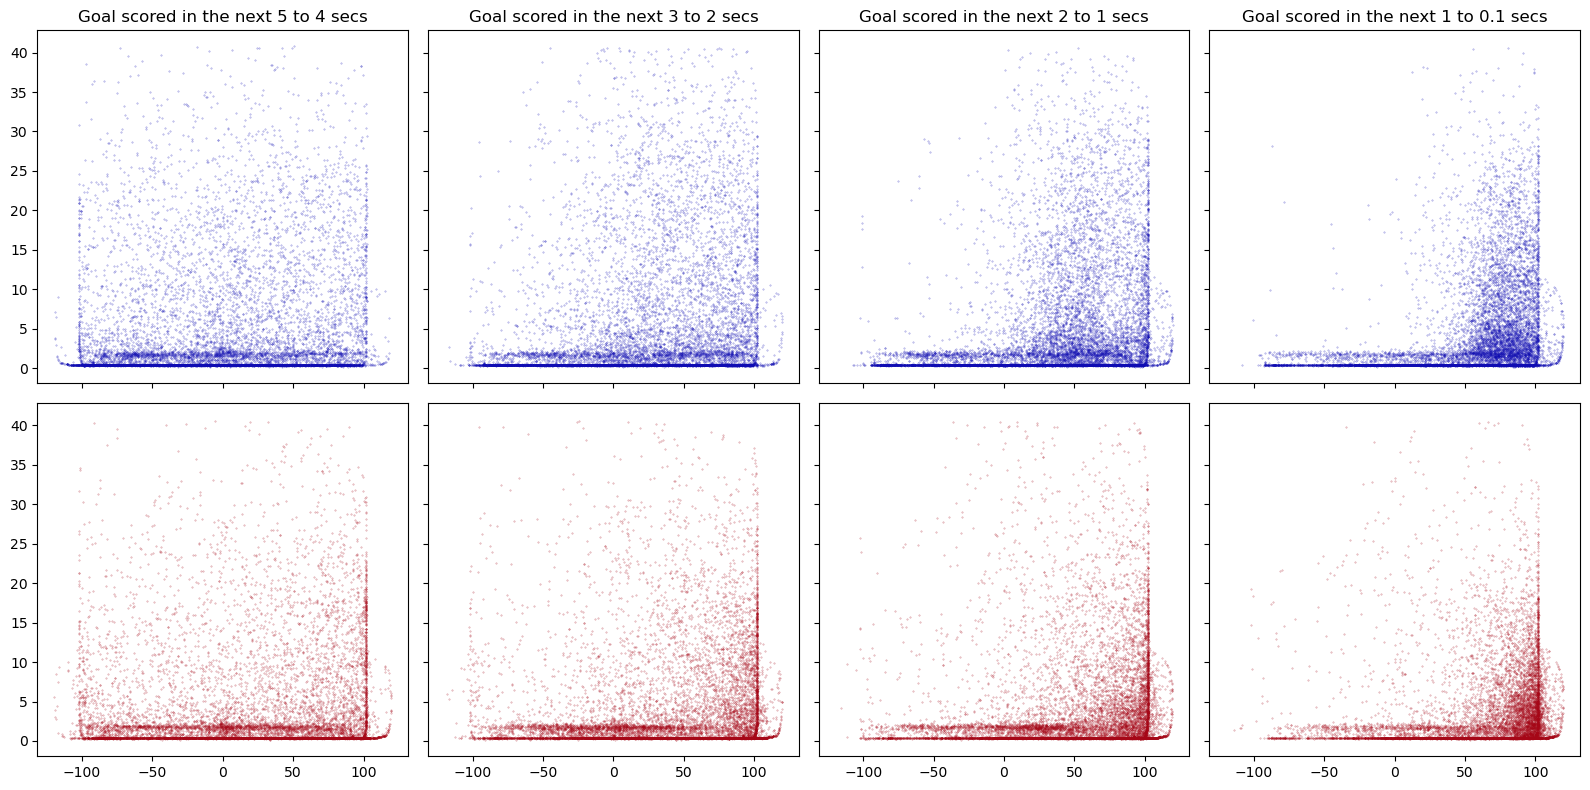

In [87]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
intervals = [(-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[0][col].scatter(tmp.p0_pos_y, tmp.p0_pos_z, s=0.1, alpha=.5, color="#0f0cb3")
    axs[0][col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
    axs[1][col].scatter(tmp.p3_pos_y, tmp.p3_pos_z, s=0.1, alpha=.5, color="#a60717")
fig.tight_layout();

#### Missing values (demolished players)

What we haven't looked at until now is the issue of demolished players. If a player gets demolished in a collision, he will miss on the pitch until he gets respawned. 

As we can see, if team A misses player(s) it is much less likely to score a goal. Thus, missing values have high predictive value. In practice, we'd probably want to dive deeper (are there any patterns relating to other variables? can we predict demolitions?); here we'll move on for the sake of brevity.

In [89]:
df["team_A_active"] = df[[f"p{i}_pos_x" for i in range(3)]].notna().sum(axis=1)

for n in range(1, 4):
    tmp = df[df.team_A_active == n]
    print("Active players team A:", n)
    print("\tAverage time to goal:", tmp.groupby("event_id")["event_time"].agg("first").mean())
    print("\tTeam A scores:", tmp.groupby("event_id")["team_A_scoring_within_10sec"].agg("first").mean())
    print()

Active players team A: 1
	Average time to goal: -56.19182
	Team A scores: 0.02766798418972332

Active players team A: 2
	Average time to goal: -52.985264
	Team A scores: 0.057919015889287544

Active players team A: 3
	Average time to goal: -36.29622
	Team A scores: 0.13558903432946406



### Player velocity

The velocity of player `i` is given by the corresponding `p{i}_vel_[xyz]` features. Again the histograms of players of the same team are identical, while the histograms of the opposing team are mirror images. The maximum velocity of a player in each dimension is `46.0` (slightly lower for `z`).

The most interesting histogram below is the one belonging to the `y` direction. Naturally, players are more often attacking than defending. But if a player drives at maximum speed it is more likely to be for the purpose of defending than attacking.

Player velocity (min/max):
x coordinate: min = -46.000	 max = 46.000
y coordinate: min = -46.000	 max = 46.000
z coordinate: min = -45.953	 max = 45.400


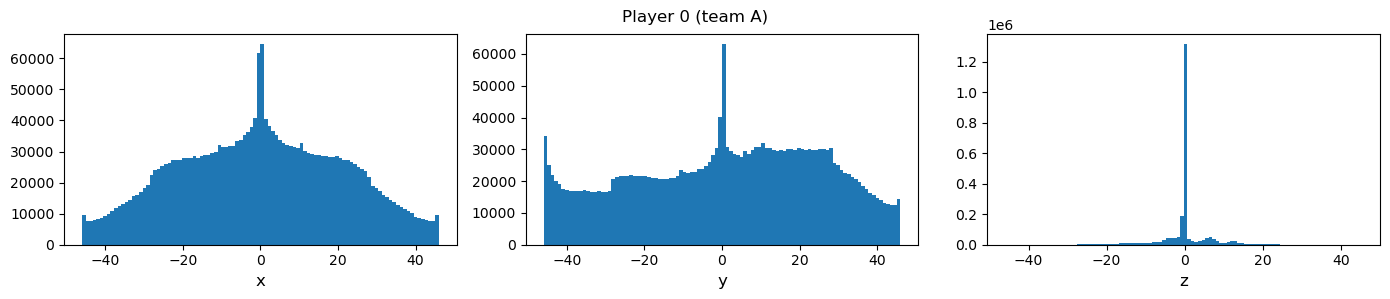

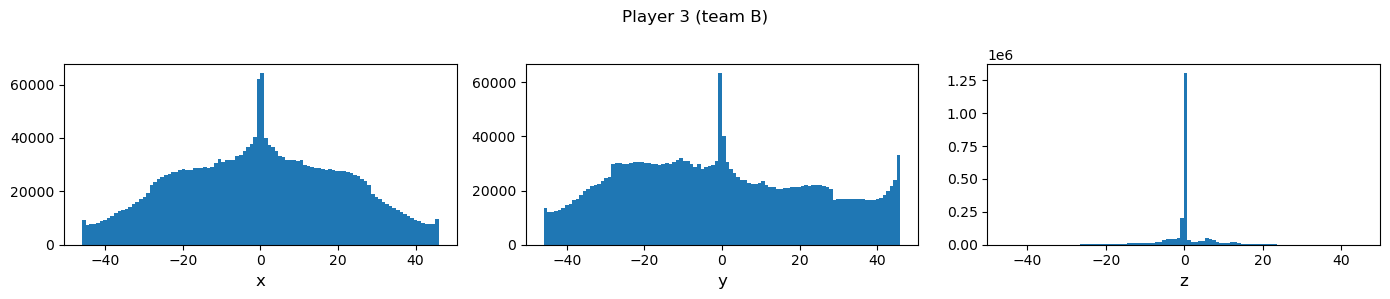

In [90]:
print("Player velocity (min/max):")
for coord in ["x", "y", "z"]:
    mi, ma = df[f"p0_vel_{coord}"].min(), df[f"p0_vel_{coord}"].max()
    print(f"{coord} coordinate: min = {mi:.3f}\t max = {ma:.3f}")

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"p0_vel_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.tight_layout()
fig.suptitle("Player 0 (team A)")
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, f in zip(axs.ravel(), ["x", "y", "z"]):
    ax.hist(df[f"p3_vel_{f}"], bins=100)
    ax.set_xlabel(f, fontsize=12)
fig.suptitle("Player 3 (team B)")
fig.tight_layout()

#### Player velocity and goal scoring

When looking at the player velocity in the last time intervals before a goal, we can see that attacking players show an increasing `y` velocity while the `z` velocity tends to decrease. This holds true for defending players, even though to a lesser extent. For the `x` velocity, extreme values become increasingly less common the closer we get to the goal.

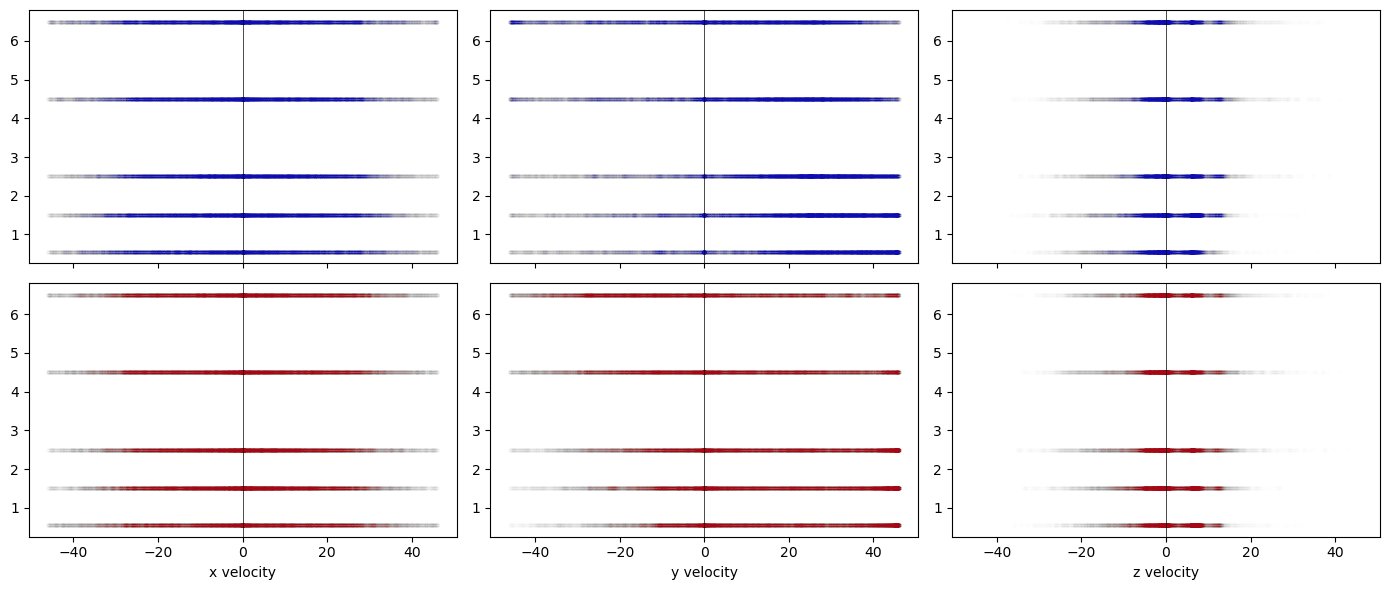

In [91]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, c in enumerate(["x", "y", "z"]):
    axs[1][col].set_xlabel(f"{c} velocity")
    axs[0][col].axvline(0, color="black", lw=0.5)
    axs[1][col].axvline(0, color="black", lw=0.5)
    for interval in intervals:
        tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
        tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
        m = abs(interval[0] + interval[1])/2
        axs[0][col].scatter(tmp[f"p0_vel_{c}"], np.repeat(m, tmp.shape[0]), s=7.5, alpha=.005, color="#0f0cb3")
        axs[1][col].scatter(tmp[f"p3_vel_{c}"], np.repeat(m, tmp.shape[0]), s=7.5, alpha=.005, color="#a60717")
fig.tight_layout();

Plotting two dimensions against each other reveals further interesting patterns. When looking at the left column (`x` versus `y`) we can see that there are two rings corresponding to the maximum velocity with and without boost. In the last seconds before a goal attacking players tend to use boost in the `y` direction.

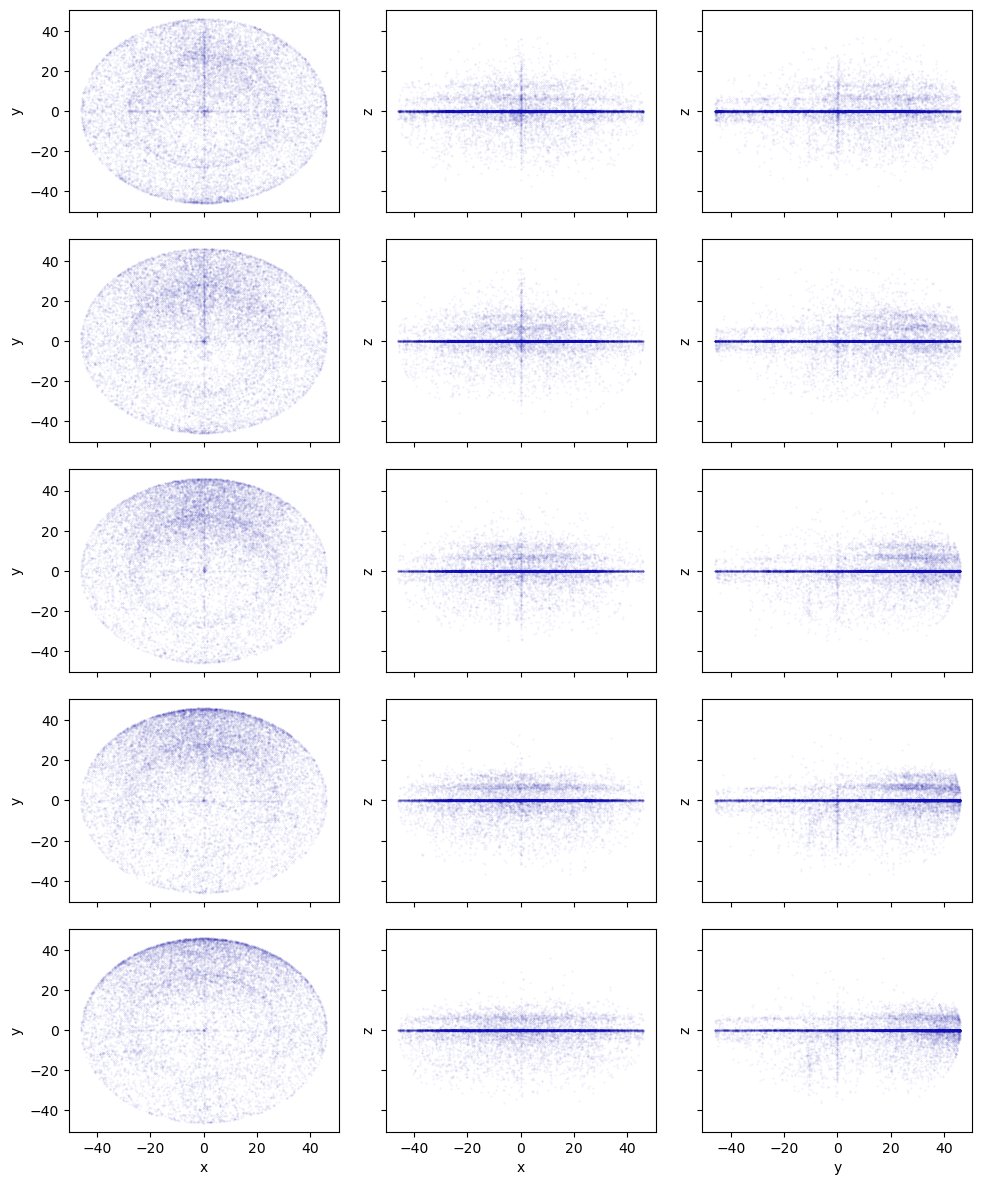

In [92]:
fig, axs = plt.subplots(5, 3, figsize=(10, 12), sharex=True, sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for row, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[row][0].scatter(tmp.p0_vel_x, tmp.p0_vel_y, s=0.1, alpha=0.1, color="#0f0cb3")
    if row == 4: axs[row][0].set_xlabel("x")
    axs[row][0].set_ylabel("y")
    axs[row][1].scatter(tmp.p0_vel_x, tmp.p0_vel_z, s=0.1, alpha=0.1, color="#0f0cb3")
    if row == 4: axs[row][1].set_xlabel("x")
    axs[row][1].set_ylabel("z")
    axs[row][2].scatter(tmp.p0_vel_y, tmp.p0_vel_z, s=0.1, alpha=0.1, color="#0f0cb3")
    if row == 4: axs[row][2].set_xlabel("y")
    axs[row][2].set_ylabel("z")
fig.tight_layout();

Comparing this to the scatterplots for team `B` shows two things:
- defending players are more likely to use boost for maximum velocity when rushing back to defend their own goal (this is probably a very good indicator for an imminent goal)
- defending players make significantly less use of the `z` dimension in the last seconds before a goal than attacking players

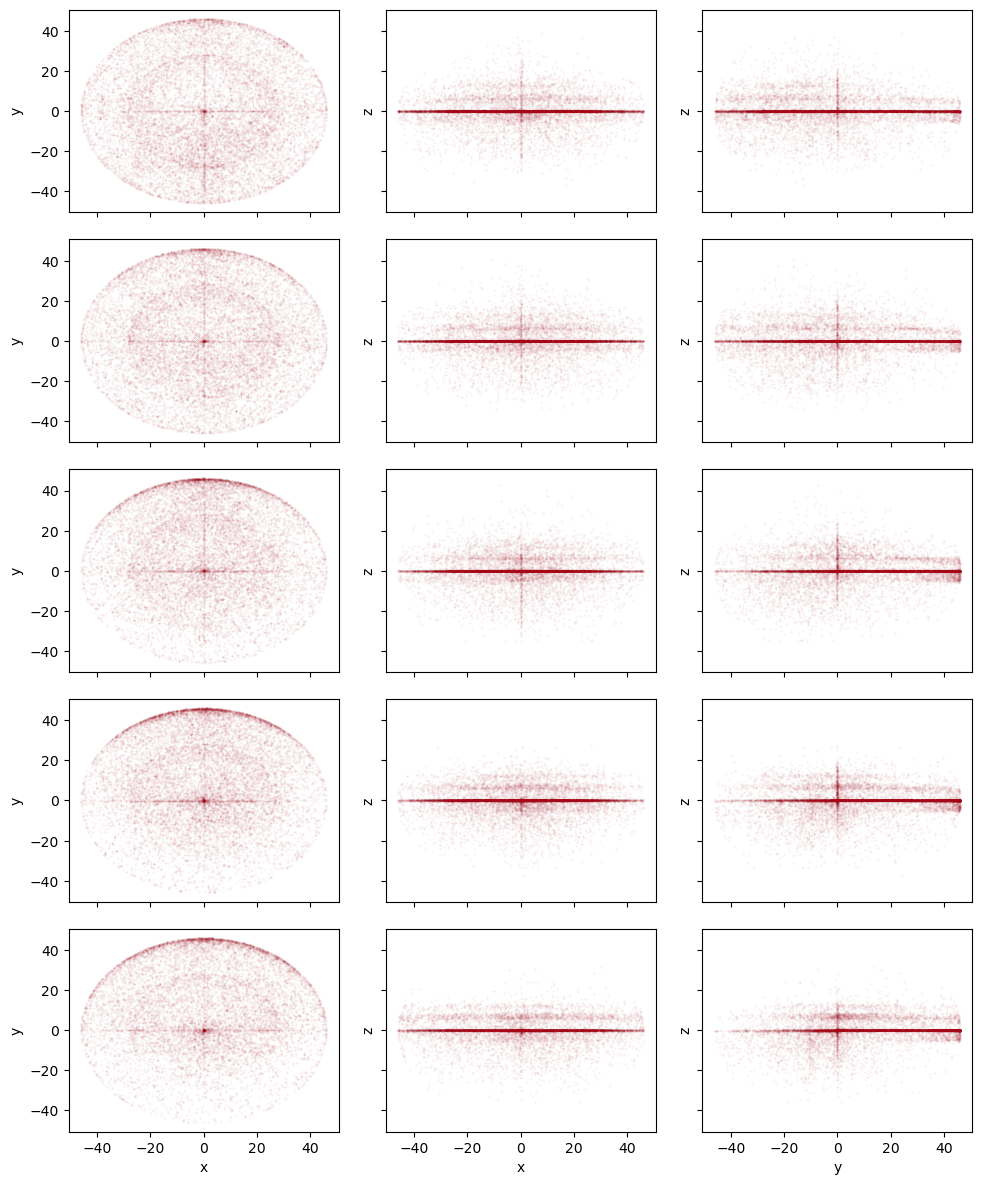

In [93]:
fig, axs = plt.subplots(5, 3, figsize=(10, 12), sharex=True, sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for row, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[row][0].scatter(tmp.p3_vel_x, tmp.p3_vel_y, s=0.1, alpha=0.1, color="#a60717")
    if row == 4: axs[row][0].set_xlabel("x")
    axs[row][0].set_ylabel("y")
    axs[row][1].scatter(tmp.p3_vel_x, tmp.p3_vel_z, s=0.1, alpha=0.1, color="#a60717")
    if row == 4: axs[row][1].set_xlabel("x")
    axs[row][1].set_ylabel("z")
    axs[row][2].scatter(tmp.p3_vel_y, tmp.p3_vel_z, s=0.1, alpha=0.1, color="#a60717")
    if row == 4: axs[row][2].set_xlabel("y")
    axs[row][2].set_ylabel("z")
fig.tight_layout();

### Player boost

For each player `i`, the remaining boost (a value between `0` and `100`) is provided in the `p{i}_boost` feature. Using boost increases a player's speed and is required to go up in the `z` dimension. The histogram (similar for all players) shows that it is quite common for players to have no boost or full boost available. Still, players tend to use their boost in the course of the game which explains the overall uniform distribution between `0` and `100` (even though the two peaks in the lower half of the value range are striking; they are probably due to the minor boost pads which are not captured in the dataset).

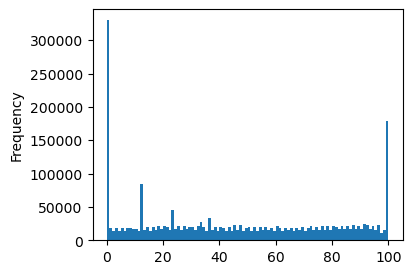

In [94]:
df.p0_boost.plot.hist(bins=100, figsize=(4, 3));

#### Player boost and goal scoring

We again look at the last seconds before a goal to see whether there are useful patterns and indeed there are:
- Players of both teams (attacking as well as defending) tend to use boost in the last seconds before a goal.
- Members of the attacking team more often use up all their boost than defending players.
- Members of the defending team more often have used up all their boost when a goal is imminent than attacking players.

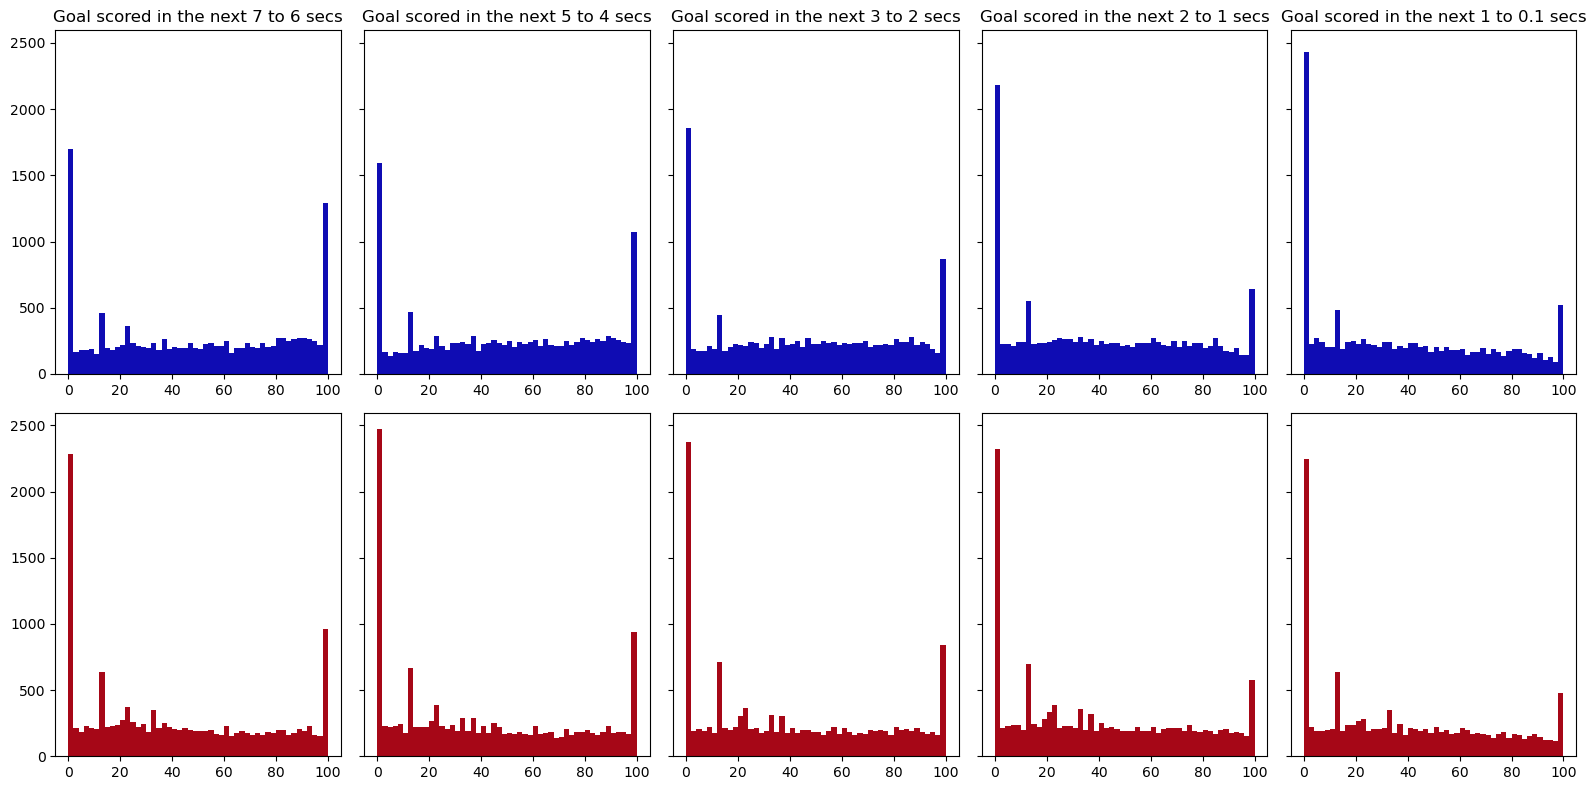

In [97]:
fig, axs = plt.subplots(2, 5, figsize=(16, 8), sharey=True)
intervals = [(-7, -6), (-5, -4), (-3, -2), (-2, -1), (-1, -0.1)]
for col, interval in enumerate(intervals):
    tmp = df[(df.event_time >= interval[0]) & (df.event_time <= interval[1])]
    tmp = tmp[tmp.team_A_scoring_within_10sec == 1]
    axs[0][col].hist(tmp.p0_boost, bins=50, color="#0f0cb3")
    axs[0][col].set_title(f"Goal scored in the next {abs(interval[0])} to {abs(interval[1])} secs")
    axs[1][col].hist(tmp.p3_boost, bins=50, color="#a60717")
fig.tight_layout();

### The target

The target is quite imbalanced: team A will score in 10 seconds in only 5.6% of our observations.

In [101]:
df.team_A_scoring_within_10sec.value_counts() / len(df)

0    0.943058
1    0.056942
Name: team_A_scoring_within_10sec, dtype: float64

### Summary

By now, we've gained a thorough understanding of the dataset and gathered many ideas that will be useful for feature engineering: computing distance measures for player positions in relation to the ball and goals, using the different patterns in player velocity and boost utilization, exploiting missing values, etc.

Of course, there are still many possibilities for exploration left and we didn't use all techniques out there. But we can (and will) always come back to analyzing our data further as our understanding of the data evolves (i.e., when we find interesting new patterns or features).

In the next post, we'll go into the theory and practice of validating and evaluating our models.